# Bounding Boxes for Cancer Dataset

### Import required libraries

In [1]:
import os
import cv2
import h5py
import glob
import random
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

## Download the Dataset

#### The *zip* files were obtained in the link https://figshare.com/articles/brain_tumor_dataset/1512427. More information can be found in the reference.

## Read matlab files and organize info in a Pandas Dataframe

Functions to extract matlab files from downloaded zip files and delete them.

In [2]:
def extract_matlab_files(zip_path):
    zip_files = glob.glob(os.path.join(zip_path, '*.zip'))
    for zip_f in zip_files:
        zipfile.ZipFile(zip_f, 'r').extractall(zip_path)
        
def remove_all_matlab_files(mat_files_path):
    files = glob.glob(os.path.join(mat_files_path, '*.mat'))
    list(map(lambda f: os.remove(f), files))

**Provide relative folder path** and extract files.

In [3]:
zip_path = Path('../Datasets/MatLab_DS')

extract_matlab_files(zip_path)

Organize each *.mat* file info in a Dataframe row.

In [4]:
def create_dataframe_with_matlab_files(matlab_files_list):

    fields = ['image', 'tumorMask', 'tumorBorder', 'PID', 'label']
    imgs_info = []

    for curr_img in matlab_files_list:
        
        # Read file and get information.
        f = h5py.File(curr_img, 'r')
        image, mask, border, P_id, label = list(map(lambda field: f.get('cjdata/' + field), fields))

        # Tranform all info to numpy.
        image = np.array(image)
        mask = np.array(mask)
        border = np.array(border)
        P_id = "".join([chr(number) for number in np.array(P_id)])
        label = np.array(label)[0][0].astype(np.int16)
        filename = os.path.basename(curr_img)

        imgs_info.append([image, mask, border, P_id, label, filename])
    

    return pd.DataFrame(imgs_info, columns=['Image_Array', 'Mask_Array', 'Tumor_Border', 'Patient_ID', 'Cancer_Type', 'MatLab_File_Name'])

In [5]:
matlab_files_list = glob.glob(os.path.join(zip_path, '*.mat'))

imgs_df = create_dataframe_with_matlab_files(matlab_files_list)
imgs_df.head()

,Image_Array,Mask_Array,Tumor_Border,Patient_ID,Cancer_Type,MatLab_File_Name
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[267.0883519862749, 143.97731474260132, 242.7...",MR034694,2,2628.mat
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[346.98257839721254, 139.14982578397212, 326....",MR049453,2,1916.mat
2,"[[0, 0, 0, 0, 0, 0, 0, 3, 7, 11, 12, 10, 11, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[188.86902810845277, 329.3275833082408, 198.4...",107429,3,1187.mat
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[289.2721296743005, 253.11311346501296, 279.9...",113554,1,161.mat
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 21, 24, 25, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[272.9477351916376, 274.7317073170732, 270.27...",MR049104,2,2855.mat


## Verify if borders match correcty with the provided masks.

Get the image and mask of the first example.

In [6]:
image, mask = imgs_df.Image_Array[0], imgs_df.Mask_Array[0]

Create an image with the tumor bounding box. 

In [7]:
x_values = imgs_df.Tumor_Border[0][0][::2]
y_values = imgs_df.Tumor_Border[0][0][1::2]

x_min = x_values.min().astype(np.int16)
x_max = x_values.max().astype(np.int16)
y_min = y_values.min().astype(np.int16)
y_max = y_values.max().astype(np.int16)

In numpy, the first index represents the **y** axis and the second, the **x** axis. We will follow the conventions of numpy and the dataset's author.

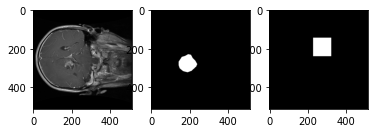

In [8]:
# Y in the first index.
borders = np.zeros_like(mask)
borders[y_min:y_max, x_min:x_max] = 255

fig = plt.figure()
sub_figs = list(map(lambda i: fig.add_subplot(1,3,i), range(1, 4)))
plots = list(map(lambda img, sf: sf.imshow(img, cmap='gray'), [image, mask, borders], sub_figs))

plt.show()

With this approach the bounding box is **not** correct. Let's switch the index reference.

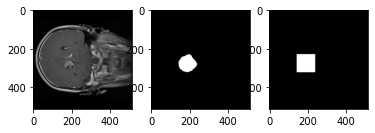

In [9]:
borders = np.zeros_like(mask)
borders[x_min:x_max, y_min:y_max] = 255

fig = plt.figure()
sub_figs = list(map(lambda i: fig.add_subplot(1,3,i), range(1, 4)))
plots = list(map(lambda image, sf: sf.imshow(image, cmap='gray'), [image, mask, borders], sub_figs))

plt.show()

We can then conclude that the coordinates must be switched.

## Switch coordinates of the border vector.

In [10]:
for tumor_border in imgs_df.Tumor_Border:
    for idx in range(0, len(tumor_border[0]), 2):
        tumor_border[0][idx], tumor_border[0][idx + 1] = tumor_border[0][idx + 1], tumor_border[0][idx]

## Save the dataframe before separation in training and testing. 

In [11]:
imgs_df.to_pickle('dataframe_brain_tumor.pickle')

## Split randomly in train and test sets

In [12]:
train_images = np.random.rand(len(imgs_df)) < 0.90

np.sum(train_images), len(train_images)

(2766, 3064)

In [13]:
imgs_df['Train_Set'] = train_images

In [14]:
imgs_df.head()

,Image_Array,Mask_Array,Tumor_Border,Patient_ID,Cancer_Type,MatLab_File_Name,Train_Set
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[143.97731474260132, 267.0883519862749, 159.9...",MR034694,2,2628.mat,True
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[139.14982578397212, 346.98257839721254, 137....",MR049453,2,1916.mat,True
2,"[[0, 0, 0, 0, 0, 0, 0, 3, 7, 11, 12, 10, 11, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[329.3275833082408, 188.86902810845277, 334.7...",107429,3,1187.mat,True
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[253.11311346501296, 289.2721296743005, 254.3...",113554,1,161.mat,True
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 15, 21, 24, 25, 3...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[274.7317073170732, 272.9477351916376, 289.89...",MR049104,2,2855.mat,True


Save *train* column as numpy.

In [15]:
np.save('train_and_valid_separation.npy', train_images)

## Save images in *train* and *val* folders.

In [16]:
train_folder = Path(os.path.join('Cheng_Dataset', 'train'))
val_folder = Path(os.path.join('Cheng_Dataset', 'val'))

train_folder.mkdir(parents=True)
val_folder.mkdir(parents=True)

### Some tests to see how the images behave when rescaled to 0-255

In [17]:
imgs_df.Image_Array[0].max(), imgs_df.Image_Array[0].min()

(1771, 0)

Here we see that images have different intensity ranges.

In [18]:
min_value = imgs_df.Image_Array[0].min()
max_value = imgs_df.Image_Array[0].max()

for img in imgs_df.Image_Array:
    max_value = img.max() if (img.max() > max_value) else max_value
    min_value = img.min() if (img.min() < min_value) else min_value

min_value, max_value

(0, 12728)

Evaluate the different ranges.

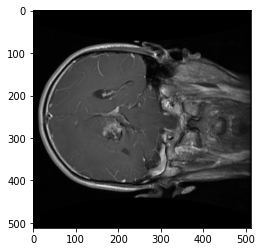

In [19]:
# Original
plt.imshow(imgs_df.Image_Array[0], cmap='gray')
plt.show()

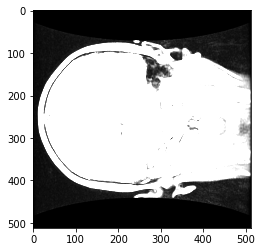

In [20]:
# Cliping intensity by 255
plt.imshow(imgs_df.Image_Array[0], cmap='gray', vmin=0, vmax=255)
plt.show()

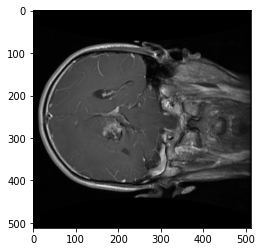

In [21]:
# Rescaled to range 0-1

rescaled = imgs_df.Image_Array[0] / imgs_df.Image_Array[0].max()

plt.imshow(rescaled, cmap='gray')
plt.show()

Rescaled to range 0-255 as int (as required to be saved).

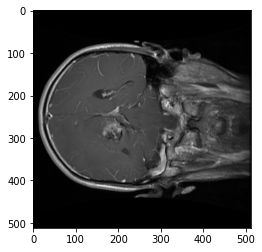

In [22]:
rescaled = (rescaled * 255.0).astype(np.uint8)
rescaled.max(), rescaled.min()

plt.imshow(rescaled, cmap='gray')
plt.show()

The quality is maintained after rescaling process.

### Save images.

In [24]:
for idx, row in imgs_df.iterrows():
    
    image = row['Image_Array']
    image = image / image.max()
    image = (image * 255.0).astype(np.uint8)

    img_name = os.path.splitext(row['MatLab_File_Name'])[0] + '.png'

    if row['Train_Set']:
        img_path = os.path.join(train_folder, img_name)
    else:
        img_path = os.path.join(val_folder, img_name)   

    pil_image = Image.fromarray(image)
    pil_image.save(img_path)

## Exclude *.mat* files

In [25]:
remove_all_matlab_files(zip_path)